## 03. Feature Engineering & 모델링


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import cross_val_score, cross_validate, cross_val_predict, GridSearchCV, KFold


In [2]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

```
Numerical Features: Age (Continuous), Fare (Continuous), SibSp (Discrete), Parch (Discrete)
Categorical Features: Survived, Sex, Embarked, Pclass
Alphanumeric Features: Ticket, Cabin
```

### 시각화

## Age 나이대별로 확인해 보자.

In [3]:
train["Age"] = train["Age"].fillna(train['Age'].median())
test["Age"] = test["Age"].fillna(test['Age'].median())

In [4]:
print( train.info(), test.info() )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            891 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
PassengerId    418 non-null int64
Pclass         418 non-null int64
Name           418 non-null object
Sex            418 non-null object
Age            418 non-null float64
SibSp          418 non-null int64
Parch          418 non-null int64
Ticket         418 non-null object
Fare           417 non-null float

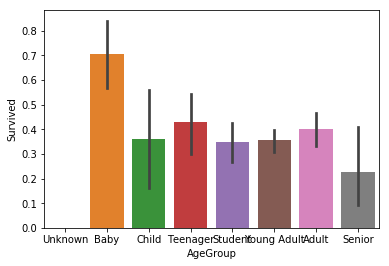

In [5]:
bins = [-1, 0, 5, 12, 18, 24, 35, 60, np.inf]  # 나이대 구분
labels = ['Unknown', 'Baby', 'Child', 'Teenager', 'Student', 'Young Adult', 'Adult', 'Senior']
train['AgeGroup'] = pd.cut(train["Age"], bins, labels = labels)
test['AgeGroup'] = pd.cut(test["Age"], bins, labels = labels)

#draw a bar plot of Age vs. survival
sns.barplot(x="AgeGroup", y="Survived", data=train)
plt.show()

### Cabin Feature 확인
 * Cabin이 null이 아닐 경우

In [6]:
train["CabinBool"] = (train["Cabin"].notnull().astype('int'))
test["CabinBool"] = (test["Cabin"].notnull().astype('int'))

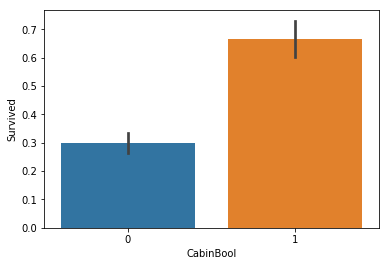

In [7]:
sns.barplot(x="CabinBool", y="Survived", data=train)

In [8]:
train["CabinBool"].value_counts()

0    687
1    204
Name: CabinBool, dtype: int64

### Cabin Feature drop

In [9]:
train = train.drop(['Cabin'], axis = 1)
test = test.drop(['Cabin'], axis = 1)

### Ticket Feature drop

In [10]:
train = train.drop(['Ticket'], axis = 1)
test = test.drop(['Ticket'], axis = 1)

### Embarked Feature

In [11]:
print( train['Sex'].value_counts() )
print( train['Embarked'].value_counts() )

male      577
female    314
Name: Sex, dtype: int64
S    644
C    168
Q     77
Name: Embarked, dtype: int64


In [12]:
train = train.fillna({"Embarked": "S"})

### Age Feature

In [13]:
#create a combined group of both datasets
combine = [train, test]

#extract a title for each Name in the train and test datasets
for dataset in combine:
    dataset['Title'] = dataset.Name.str.extract(' ([A-Za-z]+)\.', expand=False)

pd.crosstab(train['Title'], train['Sex'])

Sex,female,male
Title,,
Capt,0,1
Col,0,2
Countess,1,0
Don,0,1
Dr,1,6
Jonkheer,0,1
Lady,1,0
Major,0,2
Master,0,40


In [14]:
# 다양한 이름을 변경하기
for dataset in combine:
    dataset['Title'] = dataset['Title'].replace(['Lady', 'Capt', 'Col',
    'Don', 'Dr', 'Major', 'Rev', 'Jonkheer', 'Dona'], 'Rare')
    
    dataset['Title'] = dataset['Title'].replace(['Countess', 'Lady', 'Sir'], 'Royal')
    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

train[['Title', 'Survived']].groupby(['Title'], as_index=False).mean()

,Title,Survived
0,Master,0.575000
1,Miss,0.702703
2,Mr,0.156673
3,Mrs,0.793651
4,Rare,0.285714
5,Royal,1.000000


### 수치형 값으로 그룹을 매핑하기

### FamilySize feature

In [15]:
train['FamilySize'] = train['SibSp'] + train['Parch'] + 1
test['FamilySize'] = test['SibSp'] + test['Parch'] + 1

## NameLength feature

In [16]:
train["NameLength"] = train["Name"].apply(lambda x: len(x))
test["NameLength"] = test["Name"].apply(lambda x: len(x))

In [17]:
#map each of the title groups to a numerical value
title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Royal": 5, "Rare": 6}
for dataset in combine:
    dataset['Title'] = dataset['Title'].map(title_mapping)
    dataset['Title'] = dataset['Title'].fillna(0)

train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title,FamilySize,NameLength
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S,Student,0,1,2,23
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C,Adult,1,3,2,51
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S,Young Adult,0,2,1,22
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S,Young Adult,1,3,2,44
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S,Young Adult,0,1,1,24


In [18]:
# fill missing age with mode age group for each title
mr_age = train[train["Title"] == 1]["AgeGroup"].mode() #Young Adult
miss_age = train[train["Title"] == 2]["AgeGroup"].mode() #Student
mrs_age = train[train["Title"] == 3]["AgeGroup"].mode() #Adult
master_age = train[train["Title"] == 4]["AgeGroup"].mode() #Baby
royal_age = train[train["Title"] == 5]["AgeGroup"].mode() #Adult
rare_age = train[train["Title"] == 6]["AgeGroup"].mode() #Adult

age_title_mapping = {1: "Young Adult", 2: "Student", 3: "Adult", 4: "Baby", 5: "Adult", 6: "Adult"}

In [19]:
for x in range(len(train["AgeGroup"])):
    if train["AgeGroup"][x] == "Unknown":
        train["AgeGroup"][x] = age_title_mapping[train["Title"][x]]
        
for x in range(len(test["AgeGroup"])):
    if test["AgeGroup"][x] == "Unknown":
        test["AgeGroup"][x] = age_title_mapping[test["Title"][x]]

In [20]:
#map each Age value to a numerical value
age_mapping = {'Baby': 1, 'Child': 2, 'Teenager': 3, 'Student': 4, 'Young Adult': 5, 'Adult': 6, 'Senior': 7}
train['AgeGroup'] = train['AgeGroup'].map(age_mapping)
test['AgeGroup'] = test['AgeGroup'].map(age_mapping)

train.head()

#dropping the Age feature for now, might change
train = train.drop(['Age'], axis = 1)
test = test.drop(['Age'], axis = 1)

In [21]:
#drop the name feature since it contains no more useful information.
train = train.drop(['Name'], axis = 1)
test = test.drop(['Name'], axis = 1)

In [22]:
#map each Sex value to a numerical value
sex_mapping = {"male": 0, "female": 1}
train['Sex'] = train['Sex'].map(sex_mapping)
test['Sex'] = test['Sex'].map(sex_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title,FamilySize,NameLength
0,1,0,3,0,1,0,7.2500,S,4,0,1,2,23
1,2,1,1,1,1,0,71.2833,C,6,1,3,2,51
2,3,1,3,1,0,0,7.9250,S,5,0,2,1,22
3,4,1,1,1,1,0,53.1000,S,5,1,3,2,44
4,5,0,3,0,0,0,8.0500,S,5,0,1,1,24


In [23]:
#map each Embarked value to a numerical value
embarked_mapping = {"S": 1, "C": 2, "Q": 3}
train['Embarked'] = train['Embarked'].map(embarked_mapping)
test['Embarked'] = test['Embarked'].map(embarked_mapping)

train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked,AgeGroup,CabinBool,Title,FamilySize,NameLength
0,1,0,3,0,1,0,7.2500,1,4,0,1,2,23
1,2,1,1,1,1,0,71.2833,2,6,1,3,2,51
2,3,1,3,1,0,0,7.9250,1,5,0,2,1,22
3,4,1,1,1,1,0,53.1000,1,5,1,3,2,44
4,5,0,3,0,0,0,8.0500,1,5,0,1,1,24


### Fare Feature 

In [24]:
#fill in missing Fare value in test set based on mean fare for that Pclass 
for x in range(len(test["Fare"])):
    if pd.isnull(test["Fare"][x]):
        pclass = test["Pclass"][x] #Pclass = 3
        test["Fare"][x] = round(train[train["Pclass"] == pclass]["Fare"].mean(), 4)
        
#map Fare values into groups of numerical values
train['FareBand'] = pd.qcut(train['Fare'], 4, labels = [1, 2, 3, 4])
test['FareBand'] = pd.qcut(test['Fare'], 4, labels = [1, 2, 3, 4])

#drop Fare values
train = train.drop(['Fare'], axis = 1)
test = test.drop(['Fare'], axis = 1)

C:\Users\ktm\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [25]:
train.head()

,PassengerId,Survived,Pclass,Sex,SibSp,Parch,Embarked,AgeGroup,CabinBool,Title,FamilySize,NameLength,FareBand
0,1,0,3,0,1,0,1,4,0,1,2,23,1
1,2,1,1,1,1,0,2,6,1,3,2,51,4
2,3,1,3,1,0,0,1,5,0,2,1,22,2
3,4,1,1,1,1,0,1,5,1,3,2,44,4
4,5,0,3,0,0,0,1,5,0,1,1,24,2


In [26]:
test.head()

,PassengerId,Pclass,Sex,SibSp,Parch,Embarked,AgeGroup,CabinBool,Title,FamilySize,NameLength,FareBand
0,892,3,0,0,0,3,5,0,1,1,16,1
1,893,3,1,1,0,1,6,0,3,2,32,1
2,894,2,0,0,0,3,7,0,1,1,25,2
3,895,3,0,0,0,1,5,0,1,1,16,2
4,896,3,1,1,1,1,4,0,3,3,44,2


### 모델 선택하기 

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import cross_validation
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score

# Random Forest
from sklearn.ensemble import RandomForestClassifier
# import lightgbm as lgb
from xgboost import XGBClassifier
from xgboost import plot_importance

C:\Users\ktm\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [28]:
X = train.drop(['Survived', 'PassengerId'], axis=1)
Y = train["Survived"]

x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.20, random_state = 0)

## DecisionTreeClassifier

In [29]:
#Decision Tree
from sklearn.tree import DecisionTreeClassifier

decisiontree = DecisionTreeClassifier()
decisiontree.fit(x_train, y_train)
y_pred = decisiontree.predict(x_val)
acc_decisiontree = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_decisiontree)

79.89


In [30]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

randomforest = RandomForestClassifier()
randomforest.fit(x_train, y_train)
y_pred = randomforest.predict(x_val)
acc_randomforest = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_randomforest)

84.36


In [31]:
# KNN or k-Nearest Neighbors
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(x_train, y_train)
y_pred = knn.predict(x_val)
acc_knn = round(accuracy_score(y_pred, y_val) * 100, 2)
print(acc_knn)

79.33


In [41]:
models = pd.DataFrame({
    'Model': ['KNN', 'Random Forest', 'Decision Tree',],
    'Score': [acc_knn, acc_randomforest, acc_decisiontree]})
models.sort_values(by='Score', ascending=False)

,Model,Score
1,Random Forest,84.36
2,Decision Tree,79.89
0,KNN,79.33


In [ ]:
## Random Forest

In [42]:
#set ids as PassengerId and predict survival 
ids = test['PassengerId']
predictions = randomforest.predict(test.drop('PassengerId', axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
sub = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
sub.to_csv('multimodel_rf_01.csv', index=False)

In [ ]:
## KNN

In [43]:
#set ids as PassengerId and predict survival 
ids = test['PassengerId']
predictions = knn.predict(test.drop('PassengerId', axis=1))

#set the output as a dataframe and convert to csv file named submission.csv
sub = pd.DataFrame({ 'PassengerId' : ids, 'Survived': predictions })
sub.to_csv('multimodel_knn_01.csv', index=False)